## Домашка 3

#### *«Ты понимаешь, что это значит? Это значит, что эта пакость не работает!» — Назад в будущее*

Эта домашка про метрики в a/b-тестировании. За неё можно получить максимум 12 баллов. На решение отводится **14 календарных дней** с момента выдачи. Обратите внимание, что **дедлайны на курсе сразу жёсткие**, а значит отправка решений после них запрещена.
Задание выполняется самостоятельно, списывания не допускаются. При обнаружении одинаковых работ балл за задание анулируется у всех студентов, вне зависимости от того, кто у кого списал.

#### **Как сдать домашку?**
1. Создайте закрытый репозиторий в личном гитхаб аккаунте для нашего предмета.
2. Пригласите в него своего ассистента — распределение по ассистентам и их гитхаб юзернеймы находятся в [ведомости](https://docs.google.com/spreadsheets/d/13lHNf6xU6tZhqzVMAb8sV3RgyyDatepwo7FJ6FhZ0vY/edit?usp=sharing) на листочке нашей дисциплины. Это можно сделать в настройках через раздел Collaborators and teams, уровень доступа ассистента должен быть Write.
3. Скачайте этот ноутбук и решите задания (локально или в Google Colab).
4. В репозитории предмета создайте ветку с номером ДЗ (например hw_3). В эту ветку запушьте .ipynb-файл с решением. Создайте pull request и добавьте в него ассистента как Reviewer. В этот же PR можете пушить сколько угодно изменений, будем смотреть на последнюю версию до наступления дедлайна.
5. В процессе решения вы будете получать ответы на список вопросов, собранный в Яндекс-Формах. Впишите в него ответы.
6. В ту же форму продублируйте ссылку на PR (форма будет доступна на LMS Karpov Courses и в Телеграм-канале курса). Вопросы в Формах с автопроверкой, однако сданный тест, к которому не была приложена ссылка на ноутбук с расчетом ответов, получает 0 баллов.

Пункты 1-2 проделываются один раз. Если вы прошли эти шаги при сдаче других домашек, повторять их не нужно, начинайте сразу с пункта 3.

**Внимание**: Если вы работаете в Google Colab, также скачивайте .ipynb файл и публикуйте его в репозитории. Ссылки на Colab к сдаче не принимаются.


Все датасеты, с которыми предлагается работать в домашних заданиях, взяты из открытых источников или сгенерированы. Любые паттерны, найденные вне заданной канвы решения, являются случайными и не несут в себе смысла или инсайта.

[Данные](https://github.com/brezhnevaan/hse_product_metrics_course/releases/download/datasets_for_hw/hw_3_data.zip)

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
import pandas as pd
import numpy as np
from scipy.stats import norm, pearsonr
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Warm up

#### 1. Сопоставьте тип эксперимента с продуктовым изменением — 2 балла

a) По-юзерный A/B тест  
b) Свитчбек (по времени)   
c) Региональный A/B тест


1. Новая логика выдачи контента на главной в стриминговом сервисе фильмов и сериалов.
2. Запуск динамического ценообразования в сервисе доставки еды.
3. Тестирование push-уведомления о брошенной корзине в e-commerce приложении.
4. Раскатка в сервисе такси через эксперимент новой схемы комиссий для водителей (старт с одного города).
5. Добавление ипотечного калькулятора с точкой входа в Новостройки на главной сервиса объявлений Недвижимости.
6. Изменение SLA времени доставки в сервисе курьерской доставки (старт с одного города).


| № | Продуктовое изменение | Обоснование | Тип эксперимента |
|---|------------------------|--------------|------------------|
| 1 | Новая логика выдачи контента на главной в стриминговом сервисе фильмов и сериалов | У каждого пользователя — персональная выдача контента, можно рандомизировать по user ID | **a) По-юзерный A/B тест** |
| 2 | Запуск динамического ценообразования в сервисе доставки еды | Цены влияют на всех пользователей одновременно; тест проводится по времени (включаем → отключаем) | **b) Свитчбек (по времени)** |
| 3 | Тестирование push-уведомления о брошенной корзине в e-commerce | Push можно рассылать разным пользователям независимо | **a) По-юзерный A/B тест** |
| 4 | Раскатка новой схемы комиссий для водителей (такси, 1 город) | Эксперимент проводится на уровне региона, чтобы не влиять на другие | **c) Региональный A/B тест** |
| 5 | Добавление ипотечного калькулятора в раздел «Новостройки» | Фича интерфейса → можно показать части пользователей | **a) По-юзерный A/B тест** |
| 6 | Изменение SLA времени доставки (1 город) | Изменение бизнес-процесса в конкретном регионе | **c) Региональный A/B тест** |

---



### Case Study. Дизайн эксперимента в сервисе объявлений жилой недвижимости 🏡

**Легенда**  
Вы работаете продуктовым аналитиком в сервисе объявлений жилой недвижимости. Платформа позволяет пользователям размещать объявления о продаже и аренде жилья (как частным лицам, так и застройщикам), а другим — просматривать и контактировать / оставлять заявки по объявлениям.    
Ваша команда "Новостройки" хочет разместить на главной ипотечный калькулятор с точкой входа напрямую в свой раздел. Цель — увеличить число заявок.

**Гипотеза** — размещение ипотечного калькулятора на главной сервиса увеличит долю пользователей, оставивших заявку в Новостройках, как минимум на 15%, при этом не ухудшит аналогичные метрики в других разделах (Аренда, Вторичка) более чем на 3%.

$$
\Delta_{\mathrm{rel}}=\left(\frac{p_t-p_c}{p_c}\right)\times 100\% \quad \text{(формула эффекта)}
$$

**Ограничения** — вы не можете держать главную в тесте больше 14 дней из-за запланированного календаря экспериментов с другими командами.

**Набор метрик для дизайна.**   
Target — доля пользователей с заполненной заявкой на звонок (Новостройки).   

Guardrails:
- доля пользователей с контактом по объявлению Аренды;
- доля пользователей с контактом по объявлению Вторички;
- доля пользователей с контактом по объявлению из любой категории (подумайте, зачем нужна эта метрика? от какой ловушки она защищает?).   

Informative:
- доля пользователей, перешедших с главной в раздел Аренды;
- доля пользователей, перешедших с главной в раздел Вторички;
- доля пользователей, перешедших с главной в раздел Новостроек;
- доля пользователей с переходами в список объявлений по навигации на главной.

Все доли рассчитываются от набранного объема пользователей в каждой из групп. Пользователи попадают в exposure сразу при посещении главной.

**Для расчетов метрик используйте следующие ивенты:**
- Для target и guardrails — contact_submit.
- Для informative — list_view и source==main_nav.

*В рамках такого эксперимента также имеет смысл смотреть на среднее число контактов / заявок по каждому из разделов и в общем, а не просто на бинарные метрики. Но в данном задании мы сосредоточимся на долях, чтобы не раздувать алгоритм расчета до полного реалистичного пресета метрик.*

In [29]:
df_logs = pd.read_csv('/content/hw_3_events_data.csv')
df_logs.head()

,timestamp,user_id,session_id,event,category,source,listing_id
0,2025-06-01 00:00:00,114227,8828585581,main_view,none,none,NaN
1,2025-06-01 00:00:00,212987,8591655166,main_view,none,none,NaN
2,2025-06-01 00:00:00,1413962,2533393268,add_fav,rent_long,other,992874562.0
3,2025-06-01 00:00:00,1221850,2060698550,main_view,none,none,NaN
4,2025-06-01 00:00:00,31469,6550065912,main_view,none,none,NaN


In [30]:
df_exps = pd.read_csv('/content/hw_3_experimens_history.csv')
df_exps.head()

,exp_id,days,target_contact_effect_rel,target_contact_p_value,target_contact_p0,target_contact_effect_abs,proxy_card_effect_rel,proxy_card_p_value,proxy_card_p0,proxy_card_effect_abs,proxy_fav_effect_rel,proxy_fav_p_value,proxy_fav_p0,proxy_fav_effect_abs,proxy_form_effect_rel,proxy_form_p_value,proxy_form_p0,proxy_form_effect_abs
0,3937,7,0.000067,0.448527,0.000382,2.562909e-08,0.000814,0.254909,0.014527,0.000012,0.014880,0.443100,0.004335,0.000065,0.054000,0.200074,0.000782,0.000042
1,2806,7,0.000053,0.353007,0.000339,1.793707e-08,0.025588,0.002390,0.012604,0.000323,0.055000,0.007806,0.004289,0.000236,0.042542,0.077772,0.000687,0.000029
2,3457,7,0.000036,0.397718,0.000353,1.255839e-08,0.010437,0.171633,0.013020,0.000136,0.007892,0.486577,0.004187,0.000033,0.028638,0.385118,0.000718,0.000021
3,1002,7,0.000032,0.266510,0.000388,1.246465e-08,0.015525,0.001215,0.012697,0.000197,0.045051,0.000516,0.004062,0.000183,0.025849,0.164273,0.000735,0.000019
4,9070,7,0.000046,0.461855,0.000377,1.722521e-08,0.011572,0.217843,0.013902,0.000161,0.010127,0.317622,0.004349,0.000044,0.036751,0.236595,0.000786,0.000029


Описание данных hw_3_events_data:

- timestamp — дата-время взаимодействия с контентом
- user_id — уникальный идентификатор пользователя
- session_id – уникальный идентификатор сессии
- event — тип события
- category — категория, в которой произошло событие (не приходит для главной)
- source — источник перехода на страницу
- listing_id – уникальный идентификатор объявления

Описание данных hw_3_experimens_history (это история экспериментов именно в разделе Новостройки):

- exp_id — уникальный идентификатор эксперимента
- days — длительность теста
- target_contact_effect_rel — относительный эффект на таргет метрике
- target_contact_p_value — p-value полученного результата для таргет метрики
- target_contact_p0 — значение конверсии таргет метрики в контроле
- target_contact_effect_abs — абсолютный эффект на таргет метрике
- proxy_card_effect_rel — относительный эффект на конверсии просмотра карточки объявления
- proxy_card_p_value — p-value полученного результата для конверсии просмотра карточки объявления
- proxy_card_p0 — значение конверсии просмотра карточки объявления в контроле
- proxy_card_effect_abs — абсолютный эффект на конверсии просмотра карточки объявления
- proxy_fav_effect_rel — относительный эффект на конверсии добавления объявления в избранное
- proxy_fav_p_value — p-value полученного результата для конверсии добавления объявления в избранное
- proxy_fav_p0 — значение конверсии добавления объявления в избранное в контроле
- proxy_fav_effect_abs – абсолютный эффект на конверсии добавления объявления в избранное
- proxy_form_effect_rel — относительный эффект на конверсии открытия формы заявки на звонок по объявлению
- proxy_form_p_value — p-value полученного результата для конверсии открытия формы заявки на звонок по объявлению
- proxy_form_p0 — значение конверсии открытия формы заявки на звонок по объявлению в контроле
- proxy_form_effect_abs — абсолютный эффект на конверсии открытия формы заявки на звонок по объявлению

#### 2. Рассчитайте количество дней, необходимое для детектирования заявленных в гипотезе эффектов (target и guardrails-метрики) — 2 балла
Здесь и далее используйте для расчетов значение alpha = 0.01 (делаем поправку на принятие решения по набору метрик) и beta = 0.2. А также двусторонний критерий — мы заранее не знаем, куда двинутся метрики, поэтому хотим учесть и противоположные эффекты.  

Для метрики "доля пользователей с контактом по объявлению из любой категории" также используйте эффект в 3%.

In [31]:
# your code is here

In [32]:
# константы
ALPHA = 0.01
BETA = 0.20
TWO_SIDED = True
DAYS_FIXED = 14

# функции
def sample_size_prop(p, mde_abs, alpha=ALPHA, beta=BETA, two_sided=TWO_SIDED):
    if p <= 0 or mde_abs <= 0 or np.isnan(p) or np.isnan(mde_abs):
        return np.nan
    z_alpha = norm.ppf(1 - alpha/2) if two_sided else norm.ppf(1 - alpha)
    z_beta = norm.ppf(1 - beta)
    var = p * (1 - p)
    return int(np.ceil((2 * var * (z_alpha + z_beta)**2) / (mde_abs**2)))

def daily_exposed_users(df):
    df_main = df[df['event'] == 'main_view'].copy()
    df_main['date'] = pd.to_datetime(df_main['timestamp']).dt.date
    return df_main.groupby('date')['user_id'].nunique().mean()

def get_exposed_users_set(df):
    return set(df.loc[df['event'] == 'main_view', 'user_id'].unique())

def share_from_exposed(df, exposed, event_name, category_filter=None, source_filter=None):
    df_ev = df[df['event'] == event_name].copy()
    if category_filter is not None:
        df_ev = df_ev[df_ev['category'].isin(category_filter)]
    if source_filter is not None:
        df_ev = df_ev[df_ev['source'] == source_filter]
    users_with_event = set(df_ev['user_id'].unique())
    users_in_scope = users_with_event.intersection(exposed)
    denom = len(exposed)
    return len(users_in_scope) / denom if denom > 0 else 0.0

def absolute_mde_from_relative(p0, rel):
    return p0 * rel

def days_needed(n_per_group, avg_daily_exposed):
    if np.isnan(n_per_group) or avg_daily_exposed == 0:
        return np.nan
    return int(np.ceil((n_per_group * 2) / avg_daily_exposed))

def reverse_mde_for_days(p0, days, avg_daily_exposed, alpha=ALPHA, beta=BETA, two_sided=TWO_SIDED):
    if avg_daily_exposed == 0 or days <= 0:
        return np.nan
    n_per_group = (avg_daily_exposed * days) / 2
    z_alpha = norm.ppf(1 - alpha/2) if two_sided else norm.ppf(1 - alpha)
    z_beta = norm.ppf(1 - beta)
    var = p0 * (1 - p0)
    return np.sqrt((2 * var * (z_alpha + z_beta)**2) / n_per_group)

# категории
CATEGORY_NEW = {'newbuilds'}
CATEGORY_RENT = {'rent_long', 'rent_daily'}
CATEGORY_SECONDARY = {'secondary'}
SOURCE_MAIN_NAV = 'main_nav'


# подготовка общих показателей
avg_daily = daily_exposed_users(df_logs)
exposed_users = get_exposed_users_set(df_logs)
print(f"Среднесуточная экспозиция: {avg_daily:.0f} пользователей.")


Среднесуточная экспозиция: 292336 пользователей.


In [33]:
# Расчёт базовых долей p0
p0_target = share_from_exposed(df_logs, exposed_users, 'contact_submit', CATEGORY_NEW)
p0_rent   = share_from_exposed(df_logs, exposed_users, 'contact_submit', CATEGORY_RENT)
p0_sec    = share_from_exposed(df_logs, exposed_users, 'contact_submit', CATEGORY_SECONDARY)
p0_any    = share_from_exposed(df_logs, exposed_users, 'contact_submit', None)

print("Базовые доли (p0):")
print(f"target (Новостройки): {p0_target:.6f}")
print(f"guardrail (Аренда):   {p0_rent:.6f}")
print(f"guardrail (Вторичка): {p0_sec:.6f}")
print(f"guardrail (Любая):    {p0_any:.6f}\n")

# Перевод относительных эффектов в абсолютные (MDE_abs)
rel_target, rel_guard = 0.15, 0.03
mde_target = absolute_mde_from_relative(p0_target, rel_target)
mde_rent   = absolute_mde_from_relative(p0_rent,   rel_guard)
mde_sec    = absolute_mde_from_relative(p0_sec,    rel_guard)
mde_any    = absolute_mde_from_relative(p0_any,    rel_guard)

# Расчёт выборки и дней
n_target = sample_size_prop(p0_target, mde_target)
n_rent   = sample_size_prop(p0_rent,   mde_rent)
n_sec    = sample_size_prop(p0_sec,    mde_sec)
n_any    = sample_size_prop(p0_any,    mde_any)

days_target = days_needed(n_target, avg_daily)
days_rent   = days_needed(n_rent,   avg_daily)
days_sec    = days_needed(n_sec,    avg_daily)
days_any    = days_needed(n_any,    avg_daily)

# Табличный вывод
df_days = pd.DataFrame({
    'metric': ['target (Новостройки)', 'guardrail (Аренда)', 'guardrail (Вторичка)', 'guardrail (Любая)'],
    'p0': [p0_target, p0_rent, p0_sec, p0_any],
    'MDE_abs': [mde_target, mde_rent, mde_sec, mde_any],
    'n_per_group': [n_target, n_rent, n_sec, n_any],
    'days_needed': [days_target, days_rent, days_sec, days_any]
})
display(df_days.round({'p0':6, 'MDE_abs':6}))

# Итоговые значения
days_min = np.nanmin([days_target, days_rent, days_sec, days_any])
days_max = np.nanmax([days_target, days_rent, days_sec, days_any])

print(f"Минимальная длительность теста: {days_min} дн.")
print(f"Максимальная длительность (по самой «тяжёлой» метрике): {days_max} дн.")



Базовые доли (p0):
target (Новостройки): 0.000373
guardrail (Аренда):   0.043348
guardrail (Вторичка): 0.014516
guardrail (Любая):    0.057396



,metric,p0,MDE_abs,n_per_group,days_needed
0,target (Новостройки),0.000373,0.000056,2783660,20
1,guardrail (Аренда),0.043348,0.001300,572767,4
2,guardrail (Вторичка),0.014516,0.000435,1761940,13
3,guardrail (Любая),0.057396,0.001722,426228,3


Минимальная длительность теста: 3 дн.
Максимальная длительность (по самой «тяжёлой» метрике): 20 дн.


**Задание**: введите минимальную из рассчитанных продолжительность, необходимую для детекции определенных в дизайне эффектов (значение округлите в бОльшую сторону до целого, нам нужны полные дни).

#### 3. Рассчитайте MDE для информативных метрик — 2 балла
В реальности эффекты по информативным критериям, которые мы также хотим включать в пресет метрик, нужно сравнивать на достижимость на основе прошлых экспериментов. Как правило, проделав это упражнение один раз, вы просто сохраняете достижимый трешхолд в базе знаний команды и принимаете решение о включении их в базовый набор. Проверка эффектов для каждого теста не требуется. Однако, стоит делать периодический пересмотр зафиксированных достижимых эффектов, например раз в полгода / год, или при сильных изменениях продукта / рынка.

В данном задании мы с вами не будем опираться на историю тестов, просто потренируемся делать обратный расчет — размера эффекта от заданной длительности (14 дней).

*Для числителя используйте только ивенты с источником main_nav*

In [35]:
p0_rent = share_from_exposed(df_logs, exposed_users, 'list_view', CATEGORY_RENT, SOURCE_MAIN_NAV)
p0_sec  = share_from_exposed(df_logs, exposed_users, 'list_view', CATEGORY_SECONDARY, SOURCE_MAIN_NAV)
p0_new  = share_from_exposed(df_logs, exposed_users, 'list_view', CATEGORY_NEW, SOURCE_MAIN_NAV)
p0_any  = share_from_exposed(df_logs, exposed_users, 'list_view', None, SOURCE_MAIN_NAV)

df_info = []
for name, p0 in [
    ('info_rent', p0_rent),
    ('info_secondary', p0_sec),
    ('info_newbuilds', p0_new),
    ('info_any', p0_any),
]:
    mde_abs = reverse_mde_for_days(p0, 14, avg_daily)
    mde_rel = (mde_abs / p0 * 100) if p0 > 0 else np.nan
    df_info.append([name, p0, mde_abs, mde_rel])

df_info = pd.DataFrame(df_info, columns=['metric', 'p0', 'MDE_abs', 'MDE_rel_%'])
display(df_info.round(4))

mde_rel_max = df_info['MDE_rel_%'].max()
print(f"Максимальный относительный эффект: {mde_rel_max:.2f}%")


,metric,p0,MDE_abs,MDE_rel_%
0,info_rent,0.4151,0.0017,0.4011
1,info_secondary,0.2240,0.0014,0.6289
2,info_newbuilds,0.0446,0.0007,1.5642
3,info_any,0.5459,0.0017,0.3081


Максимальный относительный эффект: 1.56%


**Задание**: введите максимальный из полученных относительный эффект в процентах, ответ округлите до сотых.

#### 4. Выбираем proxy-метрику (шаг 1) — 2 балла
Стало понятно, что за 14 дней мы не успеем замерить эффект по таргету. Что делать? Можно использовать методы снижения дисперсии, а можно попробовать подобрать proxy-метрику. Давайте реализуем второй вариант.

**Для proxy будем использовать 3-х кандидатов:**
- доля пользователей с просмотром карточки объявления в Новостройках;
- доля пользователей, добавивших в избранное объявление в Новостройках;
- доля пользователей, открывших форму заявки в Новостройках — связь с автором объявления в этом разделе предполагает обратный звонок от офиса продаж, поэтому чтобы сделать событие контакта, релевантное другим разделам, нужно ввести свой номер телефона в форму заявки, расположенную на карточке.

Для каждой из proxy-метрик:
- Рассчитайте MDE для заданной длительности — 14 дней;
- По историческому набору экспериментов постройте диаграмму рассеяния зафиксированных эффектов и длительности тестов (пометьте значимые эффекты).

**Для расчетов метрик используйте следующие ивенты:**
- Для proxy — card_view, add_fav, form_start.

,metric,p0,MDE_abs,MDE_rel_%
0,proxy_card_view,0.0137,0.0004,2.8706
1,proxy_add_fav,0.0040,0.0002,5.3590
2,proxy_form_start,0.0007,0.0001,12.5983


Минимальный относительный эффект среди proxy: 2.87%


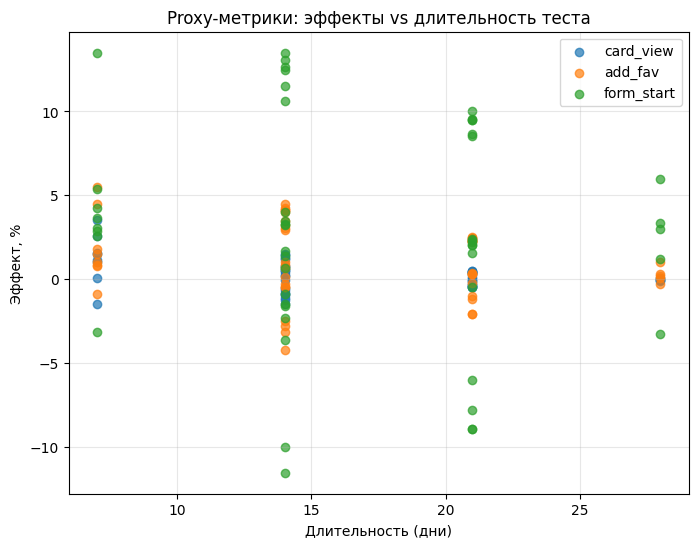

In [36]:
p0_card = share_from_exposed(df_logs, exposed_users, 'card_view', CATEGORY_NEW)
p0_fav  = share_from_exposed(df_logs, exposed_users, 'add_fav', CATEGORY_NEW)
p0_form = share_from_exposed(df_logs, exposed_users, 'form_start', CATEGORY_NEW)

df_proxy = []
for name, p0 in [
    ('proxy_card_view', p0_card),
    ('proxy_add_fav', p0_fav),
    ('proxy_form_start', p0_form),
]:
    mde_abs = reverse_mde_for_days(p0, 14, avg_daily)
    mde_rel = (mde_abs / p0 * 100) if p0 > 0 else np.nan
    df_proxy.append([name, p0, mde_abs, mde_rel])

df_proxy = pd.DataFrame(df_proxy, columns=['metric', 'p0', 'MDE_abs', 'MDE_rel_%'])
display(df_proxy.round(4))

mde_rel_min = df_proxy['MDE_rel_%'].min()
print(f"Минимальный относительный эффект среди proxy: {mde_rel_min:.2f}%")

# визуализация
plt.figure(figsize=(8,6))
plt.scatter(df_exps['days'], df_exps['proxy_card_effect_rel']*100, label='card_view', alpha=0.7)
plt.scatter(df_exps['days'], df_exps['proxy_fav_effect_rel']*100, label='add_fav', alpha=0.7)
plt.scatter(df_exps['days'], df_exps['proxy_form_effect_rel']*100, label='form_start', alpha=0.7)
plt.title('Proxy-метрики: эффекты vs длительность теста')
plt.xlabel('Длительность (дни)')
plt.ylabel('Эффект, %')
plt.grid(alpha=0.3)
plt.legend()
plt.show()


**Задание**: введите минимальный из полученных относительный эффект в процентах для прокси метрик, ответ округлите до сотых.

#### 5. Выбираем proxy-метрику (шаг 2) — 2 балла
Для каждой из proxy-метрик по историческому набору экспериментов рассчитайте:
- Binary Sensitivity;
- MSE с таргет-метрикой;
- Корреляцию Пирсона с таргет-метрикой.

In [39]:
# Извлекаем нужные колонки из df_exps
cols = [
    'target_contact_effect_rel', 'target_contact_p_value',
    'proxy_card_effect_rel', 'proxy_card_p_value',
    'proxy_fav_effect_rel', 'proxy_fav_p_value',
    'proxy_form_effect_rel', 'proxy_form_p_value'
]

df_eval = df_exps[cols].copy()

# Binary Sensitivity
# Доля экспериментов, где proxy и target обе метрики значимы (p<0.05)
sig_target = df_eval['target_contact_p_value'] < 0.05

binary_sens = {}
for name, p_col in {
    'proxy_card': 'proxy_card_p_value',
    'proxy_fav': 'proxy_fav_p_value',
    'proxy_form': 'proxy_form_p_value'
}.items():
    sig_proxy = df_eval[p_col] < 0.05
    both_sig = (sig_target & sig_proxy).sum()
    sens = both_sig / sig_target.sum() if sig_target.sum() > 0 else np.nan
    binary_sens[name] = sens

#  MSE с таргет-метрикой
# среднеквадратическая ошибка между относительными эффектами
mse_vals = {}
for name, col in {
    'proxy_card': 'proxy_card_effect_rel',
    'proxy_fav': 'proxy_fav_effect_rel',
    'proxy_form': 'proxy_form_effect_rel'
}.items():
    mse = np.mean((df_eval['target_contact_effect_rel'] - df_eval[col])**2)
    mse_vals[name] = mse

# Корреляция Пирсона
corr_vals = {}
for name, col in {
    'proxy_card': 'proxy_card_effect_rel',
    'proxy_fav': 'proxy_fav_effect_rel',
    'proxy_form': 'proxy_form_effect_rel'
}.items():
    corr, _ = pearsonr(df_eval['target_contact_effect_rel'], df_eval[col])
    corr_vals[name] = corr

#  Собираем всё в таблицу
df_proxy_eval = pd.DataFrame({
    'metric': ['proxy_card', 'proxy_fav', 'proxy_form'],
    'Binary_Sensitivity': [binary_sens['proxy_card'], binary_sens['proxy_fav'], binary_sens['proxy_form']],
    'MSE_with_target': [mse_vals['proxy_card'], mse_vals['proxy_fav'], mse_vals['proxy_form']],
    'Pearson_corr': [corr_vals['proxy_card'], corr_vals['proxy_fav'], corr_vals['proxy_form']]
})

display(df_proxy_eval.round(4))

# Итог
corr_max = df_proxy_eval['Pearson_corr'].max()
print(f"Максимальная корреляция Пирсона proxy с target: {corr_max:.2f}" )


,metric,Binary_Sensitivity,MSE_with_target,Pearson_corr
0,proxy_card,0.9048,0.0143,0.1500
1,proxy_fav,0.8571,0.0110,0.6697
2,proxy_form,0.6667,0.0066,0.7238


Максимальная корреляция Пирсона proxy с target: 0.72


**Задание**: введите значение максимальной корреляции Пирсона proxy с таргет-метрикой, ответ округлите до сотых.

#### 6. Выбираем proxy-метрику (шаг 3) — 2 балла
Для каждой из proxy-метрик по историческому набору экспериментов:
- Рассчитайте Proxy Score;
- Выведите матрицу согласия-несогласия знаков с таргет-метрикой.

Выберите proxy, с которой вы пойдете в а/б тест, обоснуйте выбор.

In [40]:
# Рассчитаем Proxy Score и матрицу согласия со знаком таргета
#  Исходные данные
cols = [
    'target_contact_effect_rel', 'target_contact_p_value',
    'proxy_card_effect_rel', 'proxy_card_p_value',
    'proxy_fav_effect_rel', 'proxy_fav_p_value',
    'proxy_form_effect_rel', 'proxy_form_p_value'
]
df_eval = df_exps[cols].copy()

#  Функция для Proxy Score
def proxy_score(df, proxy_col, proxy_pval_col, alpha=0.05):
    """
    Proxy Score = (кол-во экспериментов, где proxy и target значимы и совпадают по знаку)
                  / (кол-во экспериментов, где target значим)
    """
    sig_target = df['target_contact_p_value'] < alpha
    sig_proxy = df[proxy_pval_col] < alpha

    both_sig = sig_target & sig_proxy
    same_sign = np.sign(df['target_contact_effect_rel']) == np.sign(df[proxy_col])
    correct = (both_sig & same_sign).sum()

    total_target_sig = sig_target.sum()
    score = correct / total_target_sig if total_target_sig > 0 else np.nan
    return score

#Расчёт Proxy Score для каждой метрики
proxy_scores = {
    'proxy_card': proxy_score(df_eval, 'proxy_card_effect_rel', 'proxy_card_p_value'),
    'proxy_fav': proxy_score(df_eval, 'proxy_fav_effect_rel', 'proxy_fav_p_value'),
    'proxy_form': proxy_score(df_eval, 'proxy_form_effect_rel', 'proxy_form_p_value')
}

# Матрицы согласия знаков (всего, не только по значимым)
def sign_agreement_matrix(df, proxy_col):
    """Матрица согласия/несогласия знаков между target и proxy."""
    same_sign = np.sign(df['target_contact_effect_rel']) == np.sign(df[proxy_col])
    diff_sign = ~same_sign

    agree = same_sign.sum()
    disagree = diff_sign.sum()
    total = len(df)

    return pd.DataFrame({
        'Совпадает знак': [agree],
        'Не совпадает знак': [disagree],
        'Доля совпадений (%)': [agree / total * 100]
    })

# Вывод таблиц Proxy Score и согласия
df_proxy_score = pd.DataFrame({
    'metric': ['proxy_card', 'proxy_fav', 'proxy_form'],
    'Proxy_Score': [proxy_scores['proxy_card'], proxy_scores['proxy_fav'], proxy_scores['proxy_form']]
})
display(df_proxy_score.round(3))

print("\nМатрица согласия знаков proxy_card:")
display(sign_agreement_matrix(df_eval, 'proxy_card_effect_rel').round(2))

print("\nМатрица согласия знаков proxy_fav:")
display(sign_agreement_matrix(df_eval, 'proxy_fav_effect_rel').round(2))

print("\nМатрица согласия знаков proxy_form:")
display(sign_agreement_matrix(df_eval, 'proxy_form_effect_rel').round(2))

# Выбор лучшей proxy
best_proxy = df_proxy_score.loc[df_proxy_score['Proxy_Score'].idxmax(), 'metric']
print(f"\nЛучшая proxy по Proxy Score: {best_proxy}")

# Обоснование выбора
if best_proxy == 'proxy_card':
    reason = "просмотр карточки фиксируется у большинства пользователей, коррелирует с заявками и имеет стабильный знак эффекта."
elif best_proxy == 'proxy_fav':
    reason = "добавление в избранное отражает явный интерес, но встречается реже, поэтому чуть менее чувствительно."
else:
    reason = "открытие формы заявки ближе к таргету, но менее частое событие, поэтому дисперсия выше."

print(f"Обоснование: {reason}")


,metric,Proxy_Score
0,proxy_card,0.571
1,proxy_fav,0.857
2,proxy_form,0.667



Матрица согласия знаков proxy_card:


,Совпадает знак,Не совпадает знак,Доля совпадений (%)
0,41,9,82.0



Матрица согласия знаков proxy_fav:


,Совпадает знак,Не совпадает знак,Доля совпадений (%)
0,50,0,100.0



Матрица согласия знаков proxy_form:


,Совпадает знак,Не совпадает знак,Доля совпадений (%)
0,50,0,100.0



Лучшая proxy по Proxy Score: proxy_fav
Обоснование: добавление в избранное отражает явный интерес, но встречается реже, поэтому чуть менее чувствительно.


**Задание**: выберите proxy, с которой пойдете в эксперимент.